# This notebook serves three purposes

- Visually Unit Testing the results.
- Easy way to compare a case
- Working through the guidelines mentioned in: Paper

# Nomenclature

| Metric             | Description |
|--------------------|-------------|
| PQ                 | Panoptic Quality Metrics |
| CC                 | CC Metrics |
| Lw                 | Lesionwise Metrics |
| C                  | Cluster Metrics |
| mm                | Maximise Merge Metrics |
| b                  | Blob Metrics |

---

| Symbol            | Meaning      |
|-------------------|--------------|
| ✅                | Ideal        |
| ⚠️                | Non-ideal setting, but not *wrong* |
| ❌                | *Wrong*      |


# Code Begins

## Imports

### Common Ones

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Metrics

In [2]:
# Global Metrics
from metrics.global_metrics import dice_multiclass
from metrics.global_metrics import iou_multiclass
from metrics.global_metrics import nsd_multiclass

# Instance Sensitive Metrics
from metrics.instance_sensitive_metrics import panoptic_dice # One to One
from metrics.instance_sensitive_metrics import cc_dice # Psuedo One to One
from metrics.instance_sensitive_metrics import lesion_wise_dice # Many to 1
from metrics.instance_sensitive_metrics import cluster_dice # Many to Many
from metrics.instance_sensitive_metrics import maximised_merge_dice # Many to Many
from metrics.instance_sensitive_metrics import blob_dice # weird lol

## Helper functions for smooth testing

### Tally scores

In [3]:
## Cumulative Table
def score_list(pred, gt):
    metrics = {
        "Global": None,  # Placeholder for global metrics
        "PQ": panoptic_dice,
        "CC": cc_dice,
        "Lw": lesion_wise_dice,
        "C": cluster_dice,
        "mm": maximised_merge_dice,
        "b": blob_dice
    }
    
    metric_types = ["dice", "iou", "nsd"]
    results = {}
    
    # Add global metrics first
    results["Global"] = {
        "DICE": dice_multiclass(pred, gt).item(),  # Extract mean score
        "IOU": iou_multiclass(pred, gt).item(),  # Extract mean score
        "NSD": nsd_multiclass(pred, gt).item()  # Extract mean score
    }

    # Calculate instance-sensitive metrics
    for name, metric_fn in metrics.items():
        if name == "Global":  # Skip as we already added it
            continue
            
        results[name] = {}
        for metric_type in metric_types:
            score = metric_fn(pred, gt, metric=metric_type)
            # Handle panoptic_dice which returns float instead of tensor
            if isinstance(score, float):
                results[name][metric_type.upper()] = score
            else:
                # Handle lesion_wise_dice which returns 2D tensor
                if len(score.shape) > 0 and score.numel() > 1:
                    results[name][metric_type.upper()] = score.item()
                else:
                    results[name][metric_type.upper()] = score.item()
    
    # Create DataFrame from results
    combined_table = pd.DataFrame.from_dict(results, orient="index")
    
    return combined_table

### Visual Plot of Case

In [4]:
def plot_case(pred, gt, num_classes=8):
    """
    Visualize prediction, ground truth, and a detailed confusion visualization using seaborn styling with pastel colors.
    
    Args:
        pred: Prediction tensor (class indices)
        gt: Ground truth tensor (class indices)
        num_classes: Number of classes (including background)
    """
    
    # Set seaborn style
    sns.set(style="whitegrid", context="talk")
    plt.rcParams['axes.edgecolor'] = '0.2'
    plt.rcParams['axes.linewidth'] = 1.5
    
    # Convert tensors to numpy if they aren't already
    pred_np = pred.cpu().numpy() if hasattr(pred, 'cpu') else pred
    gt_np = gt.cpu().numpy() if hasattr(gt, 'cpu') else gt
    
    # Define fixed pastel colors for consistent appearance
    background_color = [0.97, 0.97, 0.97, 1]
    
    # Use VIBGYOR color palette for classes
    pastel_class_colors = [
        background_color,                      # Class 0 (background)
        [0.85, 0.41, 0.43, 1.0],               # Class 1 (darker pastel red)
        [0.88, 0.58, 0.40, 1.0],               # Class 2 (darker pastel orange)
        [0.92, 0.77, 0.5, 1.0],                # Class 3 (darker pastel yellow)
        [0.6, 0.75, 0.55, 1.0],                # Class 4 (darker pastel green)
        [0.55, 0.67, 0.83, 1.0],               # Class 5 (darker pastel blue)
        [0.65, 0.5, 0.75, 1.0],                # Class 6 (darker pastel indigo)
        [0.75, 0.55, 0.75, 1.0]                # Class 7 (darker pastel violet)
    ]
    
    # If num_classes > 7, extend with additional pastel colors
    if num_classes > 7:
        additional_colors = sns.color_palette("pastel", num_classes - 7)
        class_colors = pastel_class_colors + [(*color, 1.0) for color in additional_colors]
    else:
        class_colors = pastel_class_colors[:num_classes]
    
    class_cmap = mcolors.ListedColormap(class_colors)
    class_norm = mcolors.BoundaryNorm(boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes)
    
    # Create confusion visualization matrix
    confusion_vis = np.zeros_like(pred_np)
    
    # Define confusion colors (fixed for all classes)
    tp_color = [0.77, 0.60, 0.43, 1.0]  # Pastel Brown for TP
    fp_color = [0.95, 0.70, 0.80, 1.0]  # Pastel Pink for FP 
    fn_color = [0.85, 0.71, 0.85, 1.0]  # Pastel Purple for FN
    
    # Build confusion colors array
    confusion_colors = np.zeros((3*num_classes, 4))  # RGBA colors
    confusion_colors[0] = background_color  # Background (True Negatives)
    
    # Apply these fixed pastel colors to all classes
    for c in range(1, num_classes):
        # Assign colors to TP/FP/FN categories
        confusion_colors[c] = tp_color  # True positives
        confusion_colors[c + num_classes] = fp_color  # False positives
        confusion_colors[c + 2*num_classes] = fn_color  # False negatives
        
        # Fill confusion visualization matrix
        tp_mask = (pred_np == c) & (gt_np == c)
        fp_mask = (pred_np == c) & (gt_np != c)
        fn_mask = (pred_np != c) & (gt_np == c)
        
        confusion_vis[tp_mask] = c
        confusion_vis[fp_mask] = c + num_classes
        confusion_vis[fn_mask] = c + 2*num_classes
    
    confusion_cmap = mcolors.ListedColormap(confusion_colors)
    confusion_norm = mcolors.BoundaryNorm(
        boundaries=np.arange(3*num_classes + 1) - 0.5, 
        ncolors=3*num_classes
    )
    
    # Create figure with better spacing and seaborn style
    fig, ax = plt.subplots(1, 3, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.5)
    
    # Plot prediction, ground truth, and confusion visualization
    im0 = ax[0].imshow(pred_np, cmap=class_cmap, norm=class_norm, interpolation='nearest')
    ax[0].set_title('Pred', fontsize=26, pad=15)
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    
    im1 = ax[1].imshow(gt_np, cmap=class_cmap, norm=class_norm, interpolation='nearest')
    ax[1].set_title('GT', fontsize=26, pad=15)
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    
    im2 = ax[2].imshow(confusion_vis, cmap=confusion_cmap, norm=confusion_norm, interpolation='nearest')
    ax[2].set_title('Overlay', fontsize=26, pad=15)
    ax[2].set_xticklabels([])
    ax[2].set_yticklabels([])
    
    # Add colorbar for class visualization
    cbar_ax1 = fig.add_axes([0.295, 0.15, 0.025, 0.7])
    cbar1 = fig.colorbar(im0, cax=cbar_ax1)
    cbar1.set_ticks(np.arange(num_classes))
    cbar1.set_ticklabels([f'Class {i}' for i in range(num_classes)])
    cbar1.ax.tick_params(labelsize=12)
    
    # Add legend
    legend_elements = [
        Patch(facecolor=background_color, edgecolor='#dddddd', label='Background (TN)'),
        Patch(facecolor=tp_color, edgecolor='#dddddd', label='True Positives'),
        Patch(facecolor=fp_color, edgecolor='#dddddd', label='False Positives'),
        Patch(facecolor=fn_color, edgecolor='#dddddd', label='False Negatives')
    ]
    
    legend = fig.legend(
        handles=legend_elements, 
        loc='upper right', 
        bbox_to_anchor=(1.15, 1), 
        fontsize=21,
        frameon=True,
        framealpha=0.95,
        edgecolor='#dddddd',
        title="Overlay",
        title_fontsize=21
    )
    legend.get_frame().set_facecolor('#f8f9fa')
    
    # Add borders around the plots
    for a in ax:
        for spine in a.spines.values():
            spine.set_visible(True)
            spine.set_color('#dddddd')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)  # Readjust after tight_layout
    
    plt.show()
    
    return fig, ax

## Simple Binary Case showing 
- instance imbalance, and 
- difference between instance-sensitive and global metrics

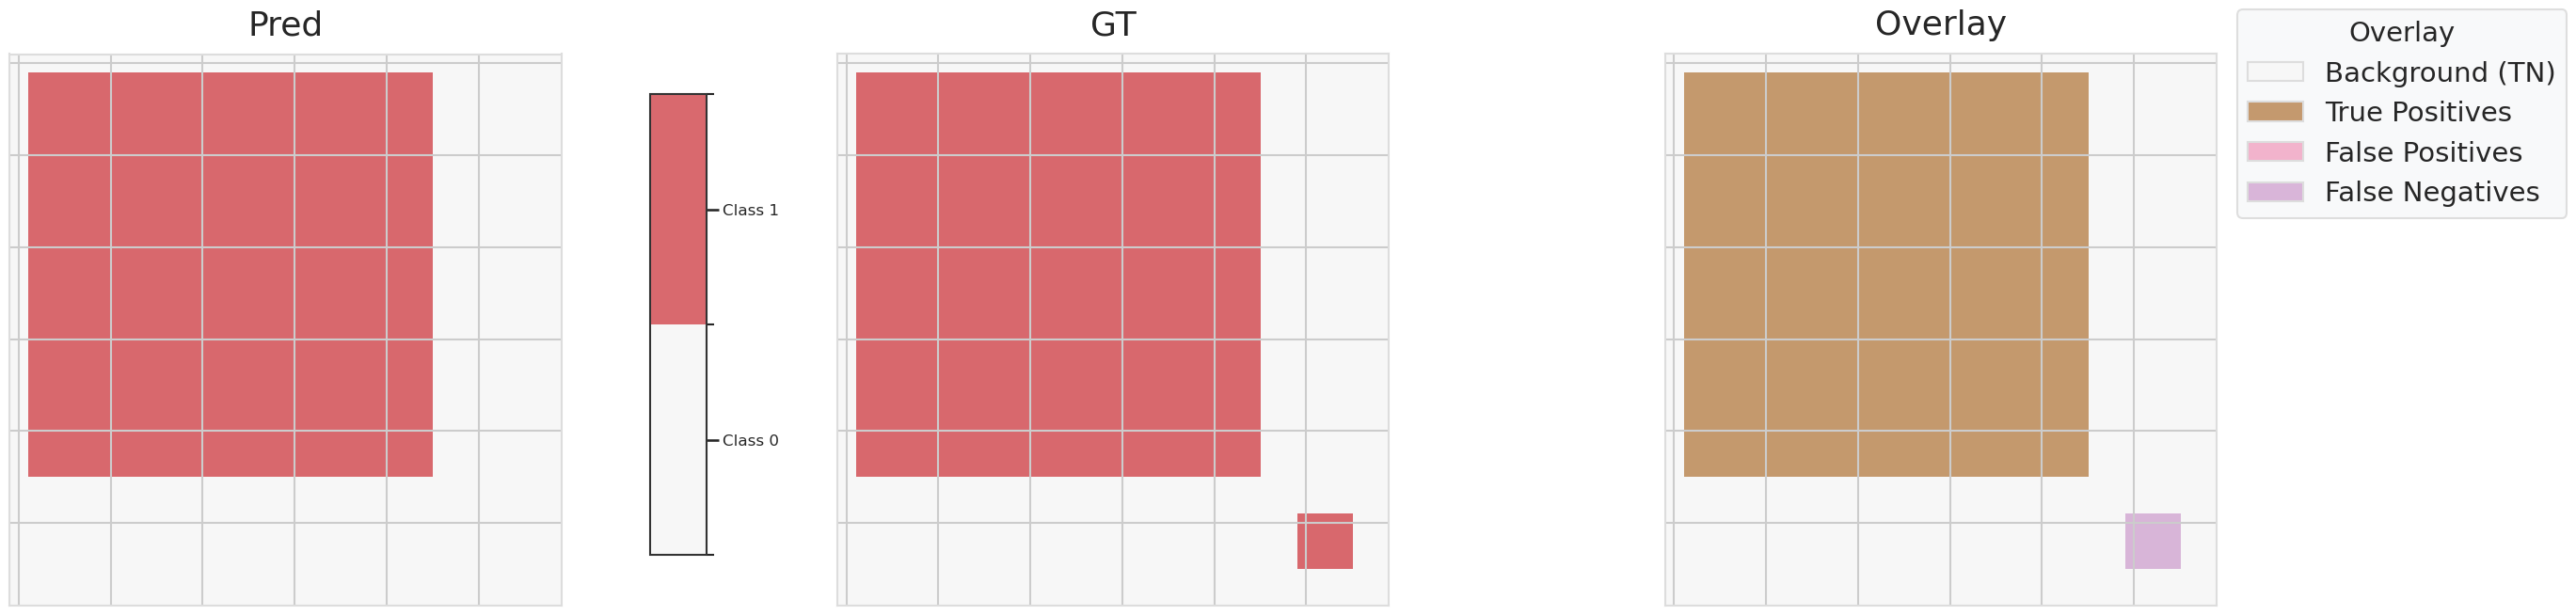

,DICE,IOU,NSD
Global,0.990788,0.981744,0.954545
PQ,0.500000,0.500000,0.500000
CC,0.500000,0.500000,0.500000
Lw,0.500000,0.500000,0.500000
C,0.500000,0.500000,0.500000
mm,0.500000,0.500000,0.500000
b,0.500000,0.500000,0.500000


In [5]:
pred = torch.zeros((30, 30)).cuda()
gt   = torch.zeros((30, 30)).cuda()

pred[1:23, 1:23] = 1
gt[1:23, 1:23] = 1

# pred[25:28, 27:31] = 1
gt[25:28, 25:28] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

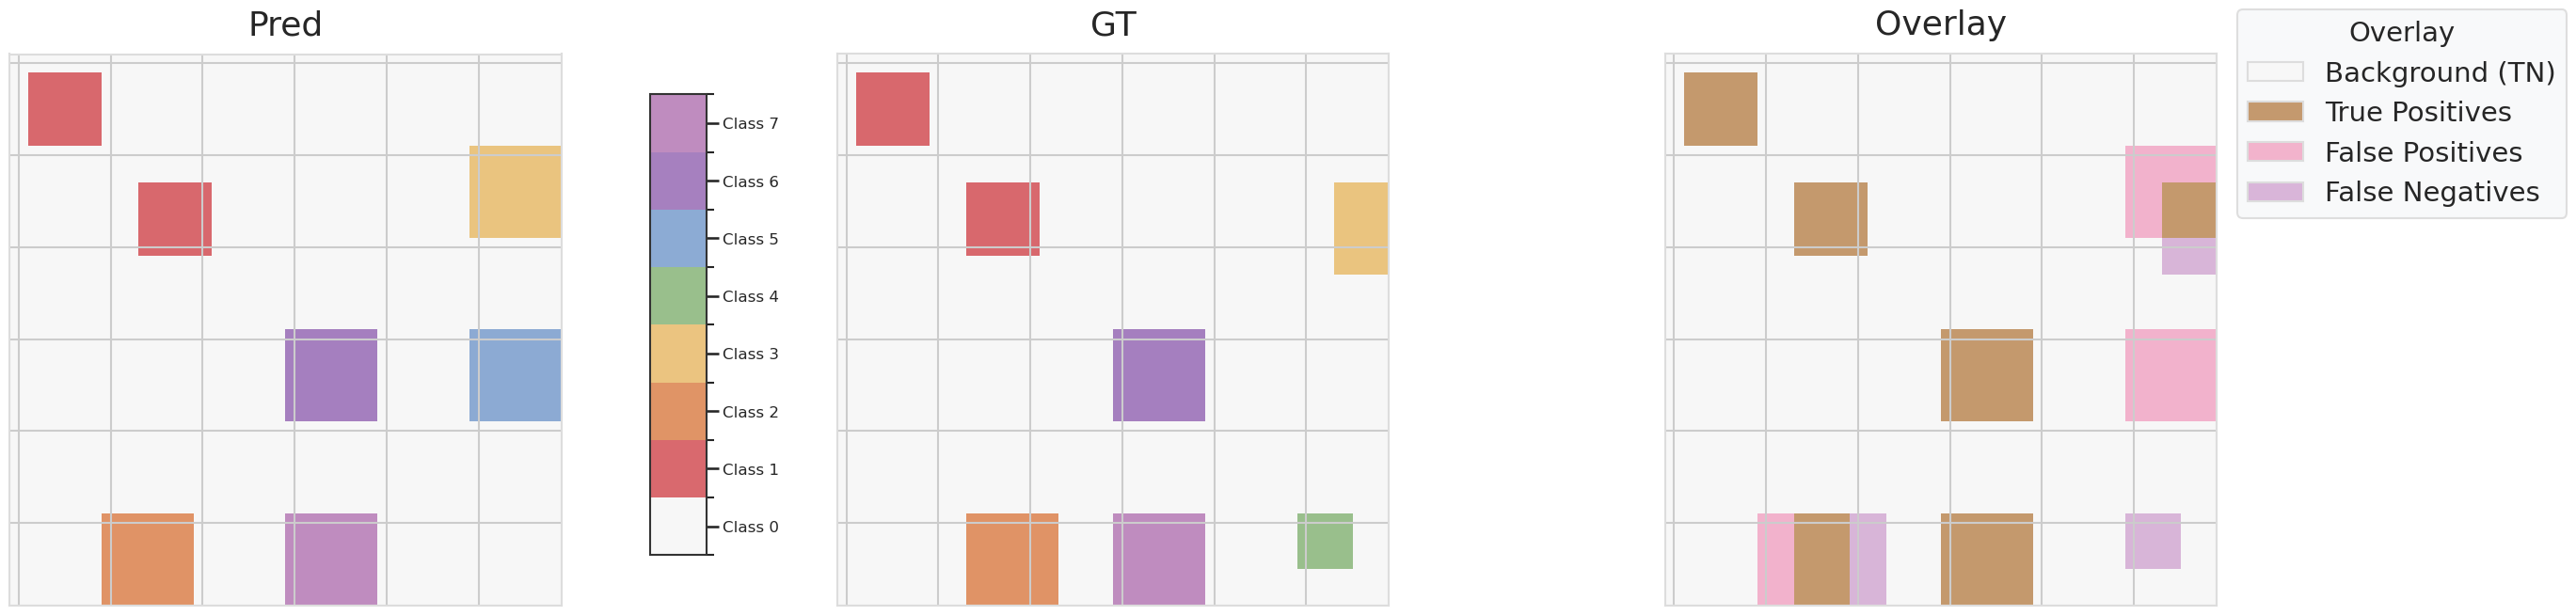

,DICE,IOU,NSD
Global,0.578571,0.531271,0.594388
PQ,0.631250,0.589862,0.645089
CC,0.578571,0.531271,0.594388
Lw,0.631250,0.589862,0.645089
C,0.578571,0.531271,0.594388
mm,0.578571,0.531271,0.594388
b,0.578571,0.531271,0.594388


In [6]:
# Sample Data
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Class 1 - Both pred and gt have the same region
pred[1:5, 1:5] = 1
gt[1:5, 1:5] = 1

# Class 1 - Both pred and gt have the same region
pred[7:11, 7:11] = 1
gt[7:11, 7:11] = 1

# Class 2 - Different regions in pred and gt
pred[25:32, 5:10] = 2
gt[25:32, 7:12] = 2  # Slight offset for partial overlap

# Class 3 - Completely different regions
pred[5:10, 25:32] = 3
gt[7:12, 27:34] = 3

# Class 4 - No prediction, only ground truth
gt[25:28, 25:28] = 4

# Class 5 - Only prediction, no ground truth
pred[15:20, 25:30] = 5

# Class 6 - Both pred and gt have the same region
pred[15:20, 15:20] = 6
gt[15:20, 15:20] = 6

# Class 7 - Both pred and gt have the same region
pred[25:30, 15:20] = 7
gt[25:30, 15:20] = 7

plot_case(pred, gt, num_classes=8)
score_list(pred, gt)

# Cases and Guidelines discussion

To kick things off, we want to discuss the guidelines points which do not need visual representation. (The details are in the paper.)

Guideline Point 1: Do all the metrics adhere to the original panoptic Guidlines? - Yes. \

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ✅  | ✅  | ✅  | ✅  | ✅  | ✅  |

Guideline Point 2: Does it consider *every* prediction instance to build the metric?

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ⚠️   | ✅  | ✅  | ✅  | ⚠️   | ✅  |

Guideline Point 3: Does it *only* need instance formation of GT?

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ⚠️   | ✅  | ⚠️   | ⚠️   | ⚠️   | ✅  |

## Guideline Point 4: Are all instances *always* equally weighed

<ins>Guide Description:</ins> Is each instance weighed equally in all cases. 

<ins> How are we showing this:</ins> By highlighting the specifc case discussed on why CC Fails. Notice:
-  the the CC Score is similar ot the global scores, and 
-  how all other instance-sensitive metrics have the same score.

<ins>Why CC Fails:</ins> In this particular case, 1 GT and Many Pred, the the region of 1 GT covers the entire volume. This means that the instance weighing for the pred instances disappears. Hence it behaves like a global metric becasue 

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ✅  | ❌  | ✅  | ✅  | ✅  | ✅  |

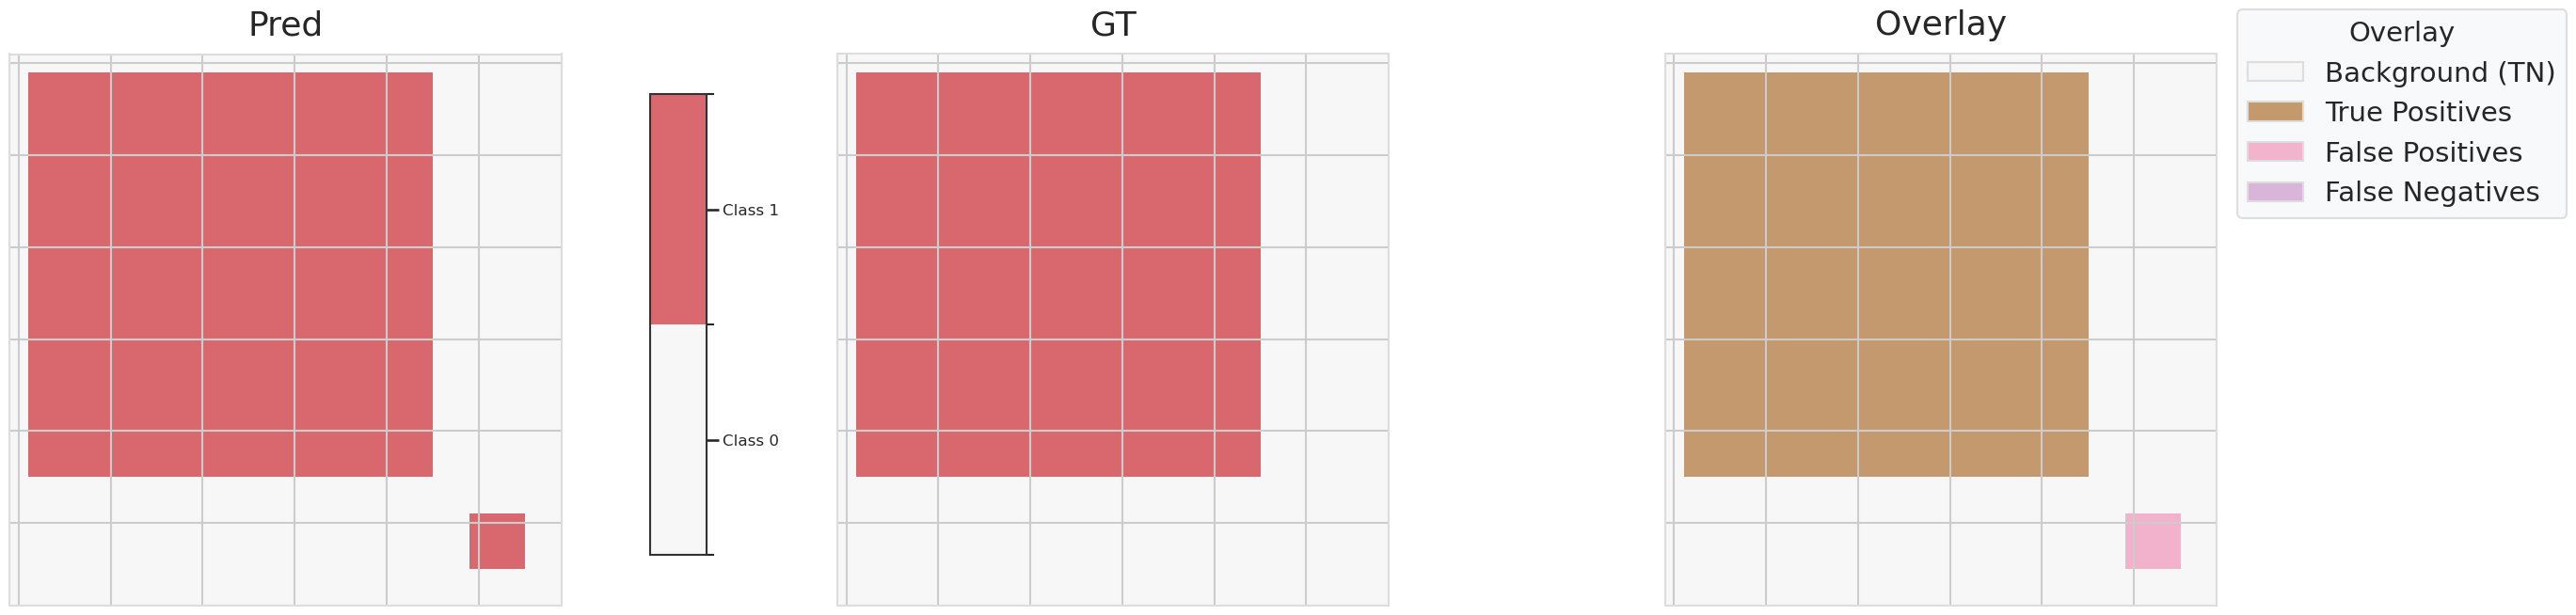

,DICE,IOU,NSD
Global,0.990788,0.981744,0.954545
PQ,0.500000,0.500000,0.500000
CC,0.990788,0.981744,0.954545
Lw,0.500000,0.500000,0.500000
C,0.500000,0.500000,0.500000
mm,0.500000,0.500000,0.500000
b,0.990788,0.981744,0.954545


In [7]:
pred = torch.zeros((30, 30)).cuda()
gt   = torch.zeros((30, 30)).cuda()

gt[1:23, 1:23] = 1
pred[1:23, 1:23] = 1

# pred[25:28, 27:31] = 1
pred[25:28, 25:28] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

## Guideline Point 5: Are multiple classes evaluated *inherently*?

<ins>Guide Description:</ins> Do scores drastically differ if the same case is posed in multiple classes? 

<ins> How are we showing this?:</ins> By comparing a simple case in binary and muilti-class and showing the score difference in both.

<ins>Why tick sign for PQ and Lw?</ins> As they rely on the counts of all classes, they are inherently multi-class.

<ins>Why Warning Sign for others?</ins> Ideally, we would want the inherent evaluation of multiple classes, and not a simple mean.

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ✅  | ⚠️  | ✅   | ⚠️   | ⚠️   | ⚠️   |

Multi-Class Case


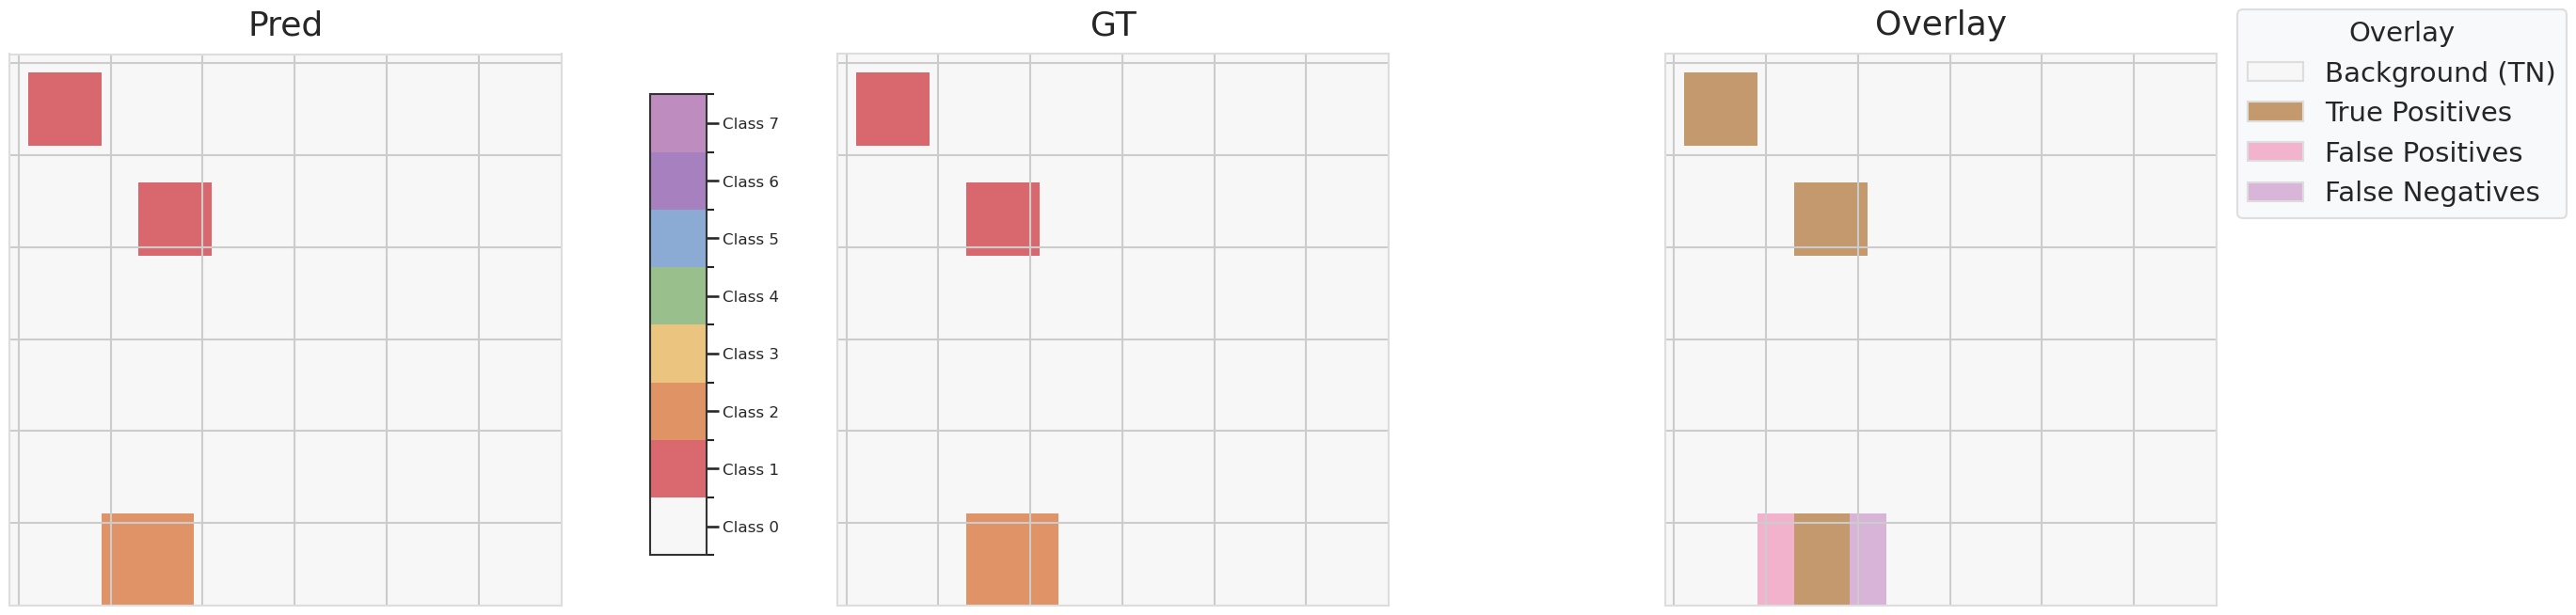

,DICE,IOU,NSD
Global,0.800000,0.714286,0.8125
PQ,0.866667,0.809524,0.8750
CC,0.800000,0.714286,0.8125
Lw,0.866667,0.809524,0.8750
C,0.800000,0.714286,0.8125
mm,0.800000,0.714286,0.8125
b,0.800000,0.714286,0.8125


In [8]:
print('Multi-Class Case')

# Sample Data
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Class 1 - Both pred and gt have the same region
pred[1:5, 1:5] = 1
gt[1:5, 1:5] = 1

# Class 1 - Both pred and gt have the same region
pred[7:11, 7:11] = 1
gt[7:11, 7:11] = 1

# Class 2 - Different regions in pred and gt
pred[25:32, 5:10] = 2
gt[25:32, 7:12] = 2  # Slight offset for partial overlap

plot_case(pred, gt, num_classes=8)
score_list(pred, gt)

Multi-Binary Case


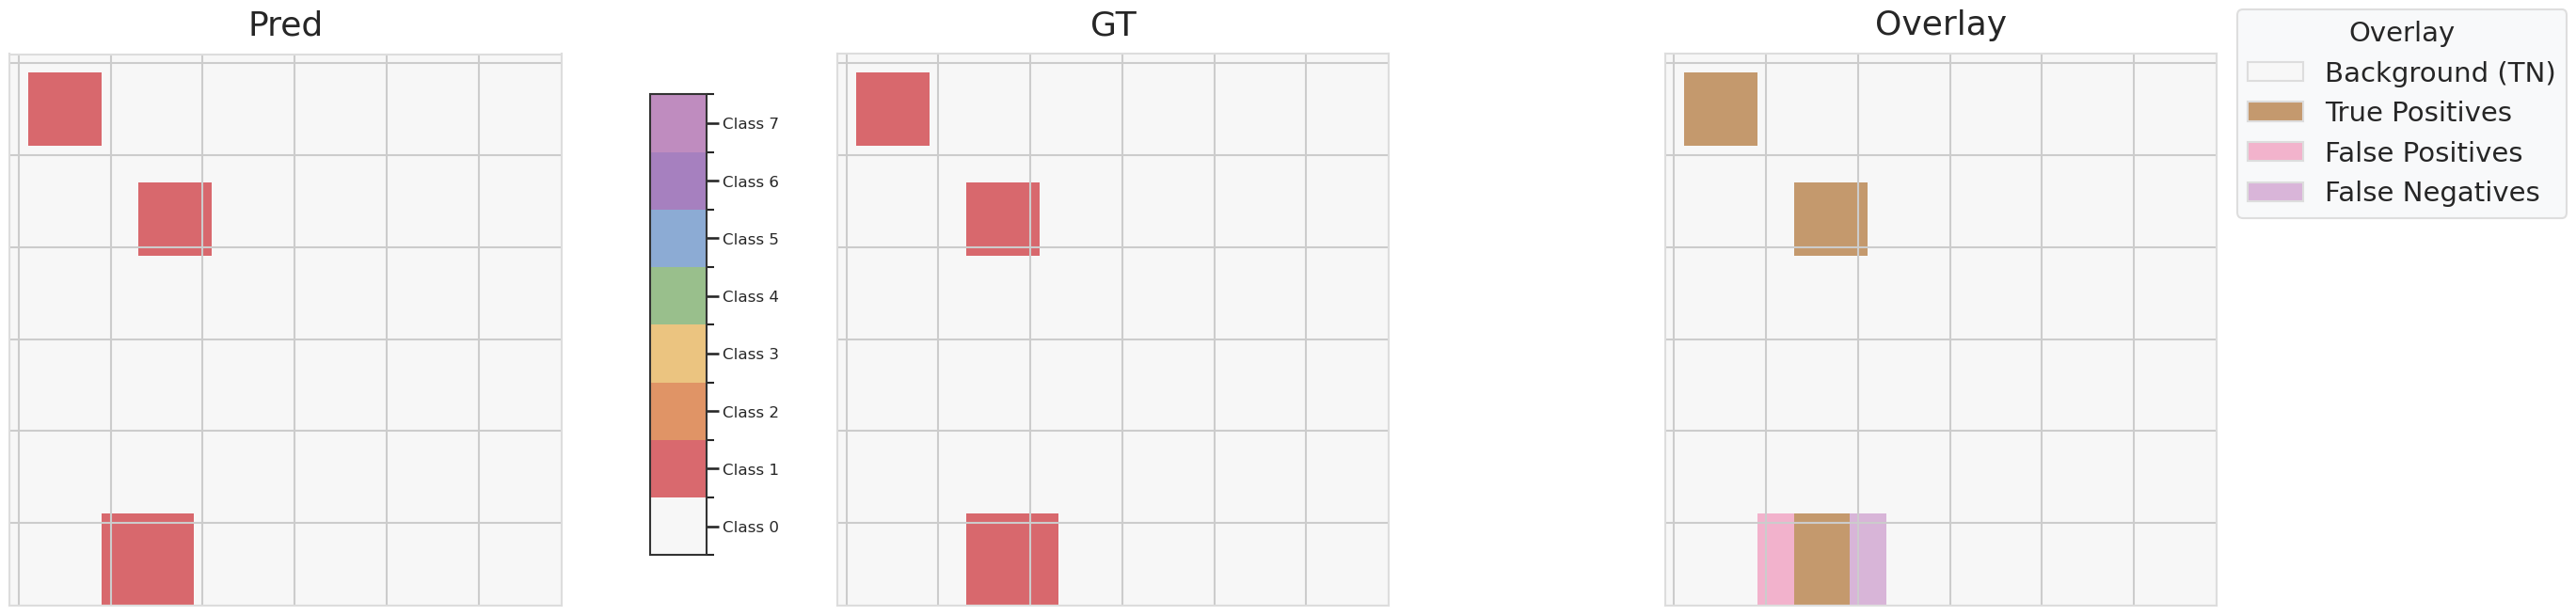

,DICE,IOU,NSD
Global,0.824561,0.701493,0.850000
PQ,0.866667,0.809524,0.875000
CC,0.866667,0.809524,0.875000
Lw,0.866667,0.809524,0.875000
C,0.866667,0.809524,0.875000
mm,0.866667,0.809524,0.875000
b,0.707937,0.553114,0.678922


In [9]:

print('Multi-Binary Case')

# Sample Data
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Class 1 - Both pred and gt have the same region
pred[1:5, 1:5] = 1
gt[1:5, 1:5] = 1

# Class 1 - Both pred and gt have the same region
pred[7:11, 7:11] = 1
gt[7:11, 7:11] = 1

# Class 2 - Different regions in pred and gt
pred[25:32, 5:10] = 1
gt[25:32, 7:12] = 1  # Slight offset for partial overlap

plot_case(pred, gt, num_classes=8)
score_list(pred, gt)

## Guideline Point 6: Is there semantic stability?

<ins>Guide Description:</ins> Throughout the metric computation, does a pixel have the same count assignment?

<ins> How are we showing this?:</ins> By choosing a case which highlights the shift in count assignment of the pixel. Difficult to notice from the score itself so details in the paper. Here we just show the case we discuss in the paper.

<ins>Sign Assignment</ins> Self explanatory.

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ❌  | ✅  | ❌  | ✅  | ✅  | ❌  |

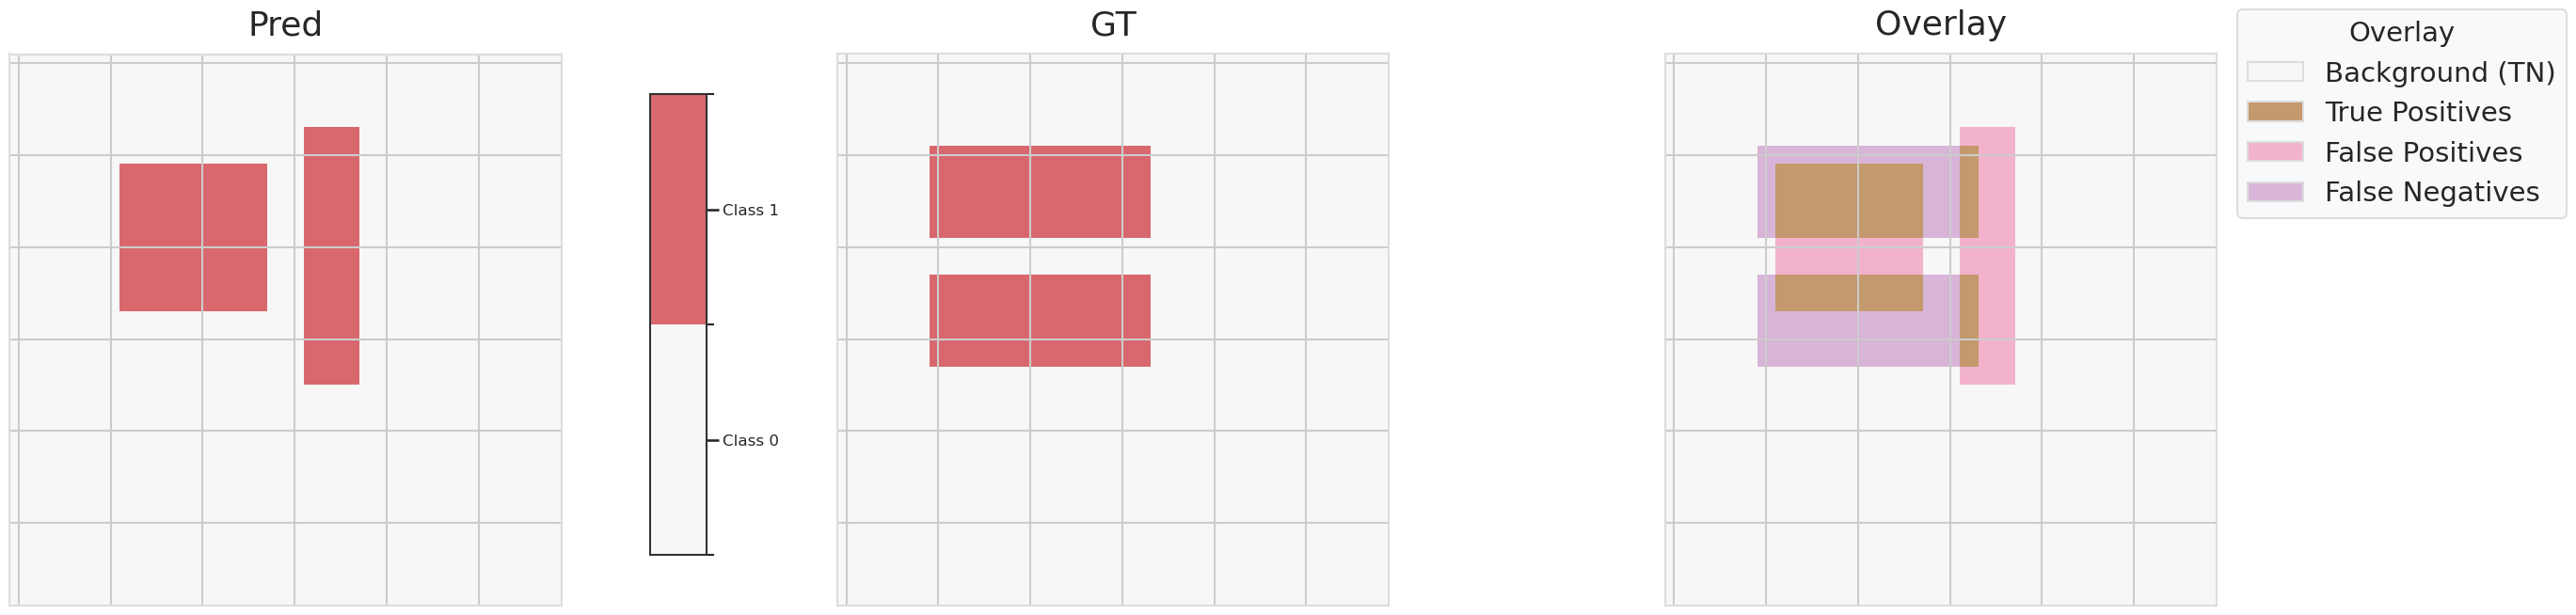

,DICE,IOU,NSD
Global,0.513274,0.345238,0.703390
PQ,0.307084,0.199686,0.392529
CC,0.505785,0.345238,0.747702
Lw,0.349398,0.215825,0.471591
C,0.513274,0.345238,0.703390
mm,0.521739,0.352941,0.703390
b,0.417963,0.268519,0.505060


In [10]:
pred = torch.zeros((30, 30)).cuda()
gt   = torch.zeros((30, 30)).cuda()

gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

pred[4:18, 16:19] = 1

pred[6:14, 6:14] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

# A nice case to show the use case of mmDICE

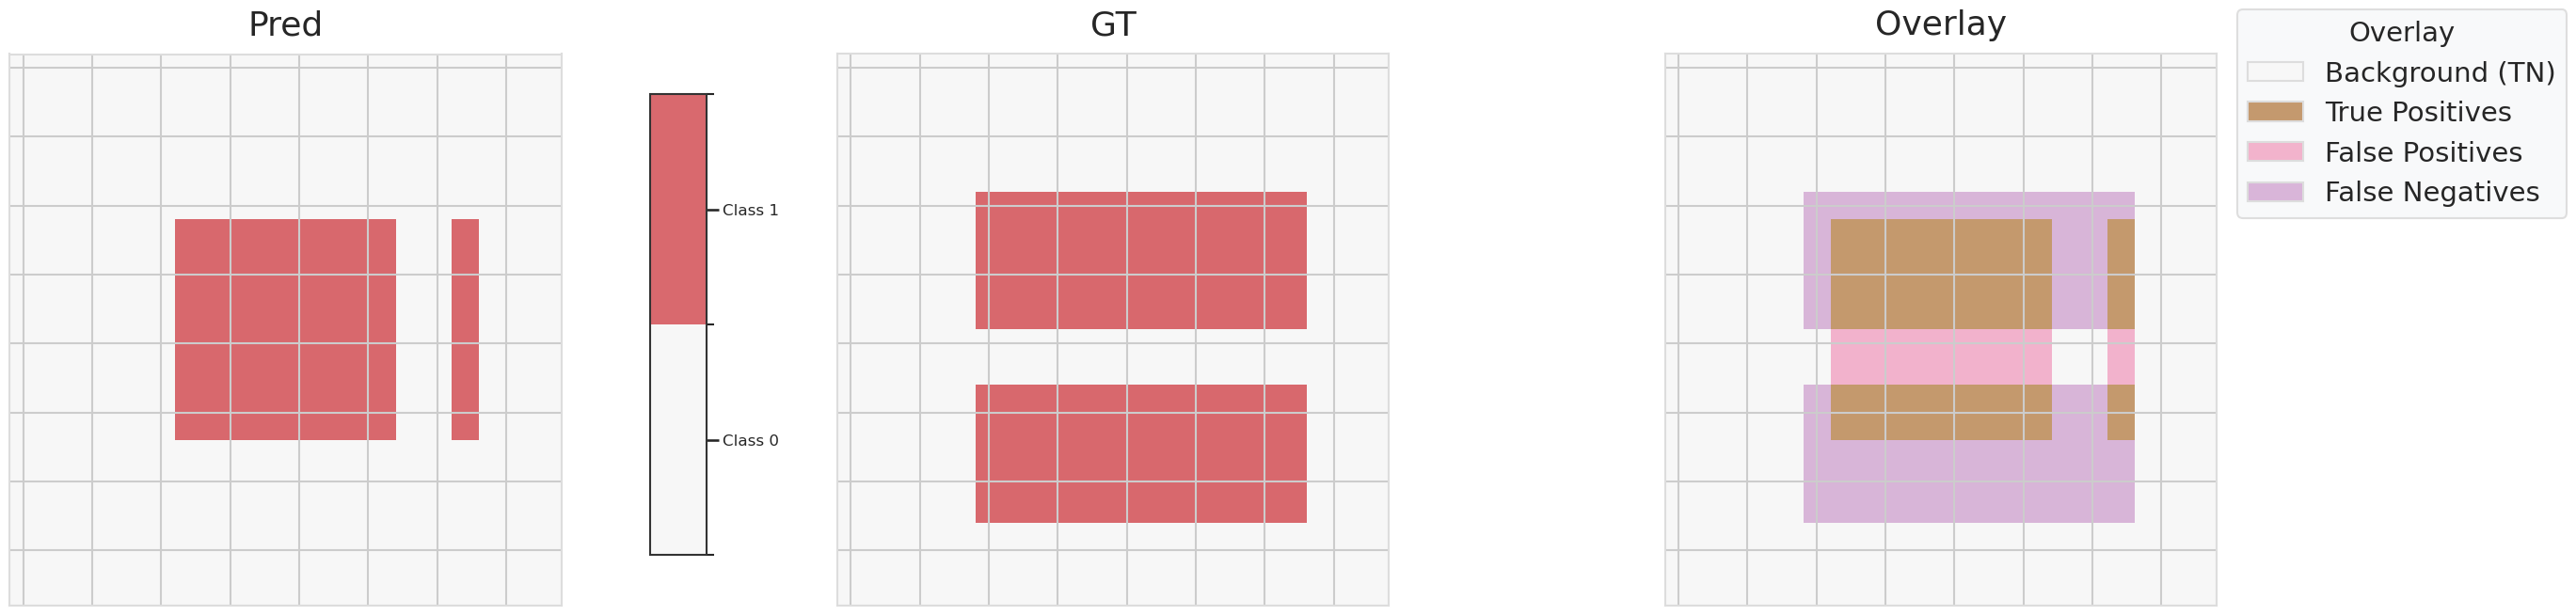

,DICE,IOU,NSD
Global,0.562500,0.391304,0.760417
PQ,0.287476,0.189065,0.367967
CC,0.549754,0.391304,0.817853
Lw,0.409091,0.266447,0.553030
C,0.562500,0.391304,0.760417
mm,0.562500,0.391304,0.760417
b,0.503289,0.346154,0.636111


In [11]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1


plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

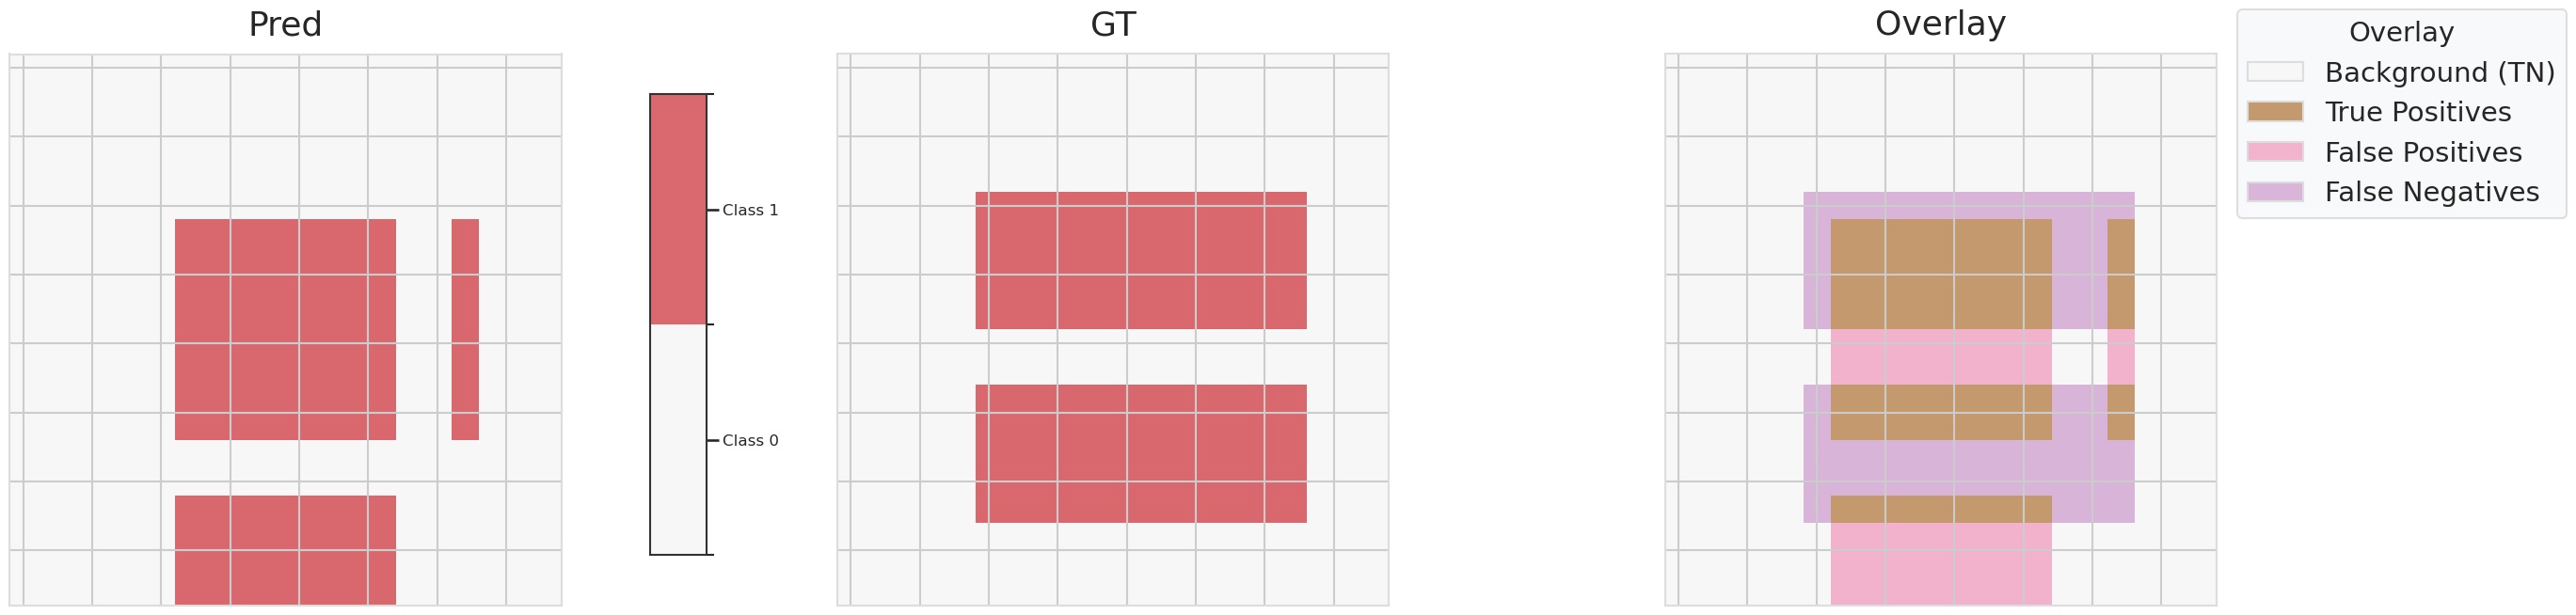

,DICE,IOU,NSD
Global,0.553571,0.382716,0.801724
PQ,0.345021,0.221532,0.475862
CC,0.561345,0.400654,0.859279
Lw,0.431264,0.281703,0.616455
C,0.553571,0.382716,0.801724
mm,0.562500,0.391304,0.801724
b,0.463995,0.303922,0.613479


In [12]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1

# Bad Pred
pred[16:20, 6:14] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

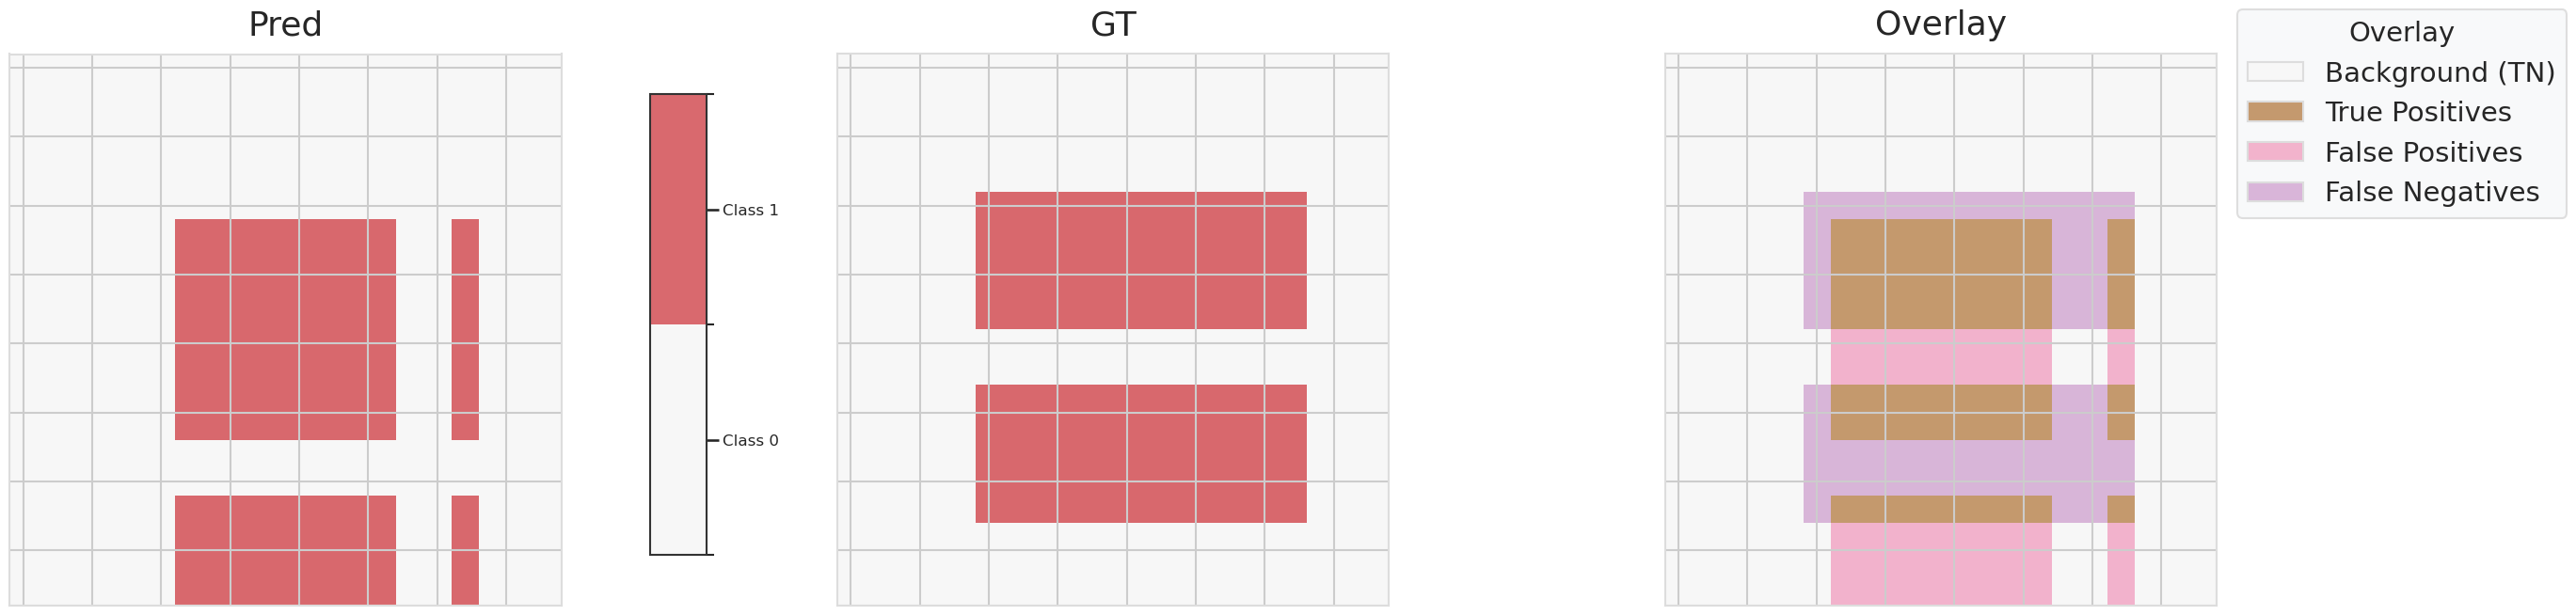

,DICE,IOU,NSD
Global,0.552632,0.381818,0.816667
PQ,0.345021,0.221532,0.475862
CC,0.562369,0.401495,0.871579
Lw,0.433442,0.283245,0.631313
C,0.552632,0.381818,0.816667
mm,0.562500,0.391304,0.816667
b,0.459865,0.300000,0.617996


In [13]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1

# Bad Pred
pred[16:20, 6:14] = 1

# Bad Pred
pred[16:20, 16:17] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)